# Graph Neural Networks For Numerical Weather Prediction

## Overview 

Graphs are a useful way to represent objects and their connections to other things. Graph neural networks (GNNs) allow us to use the abilities of deep learning and neural networks on data and problems that can be structured as graphs. This is becoming particularly important for weather and climate data science as they can effectively utilise the relational inductive bias that graph neural networks provide. 

## Graphs 

A graph is a way to represent a set of objects (nodes/vertices), and the connections between them (edges). To be able to use graph data in a neural network we need to represent it in a suitable format. Mathematically, a graph $G$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges $E$: $G = (V, E)$. Each edge is a pair of two nodes, and represents a connection between them.

For example, the graph ... 

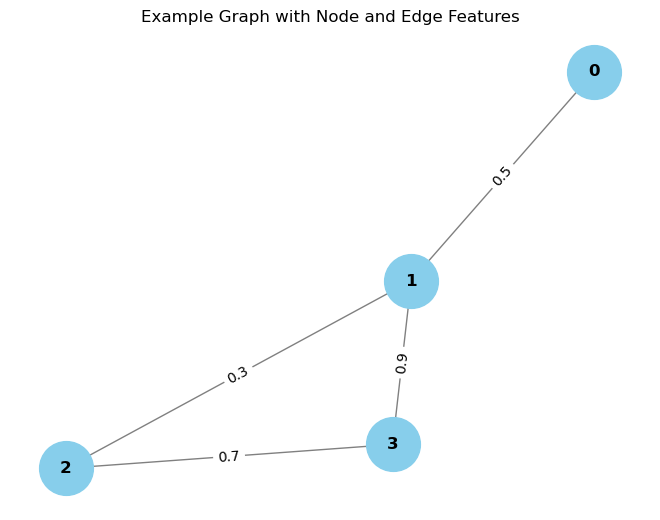

In [53]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

# Add nodes with features
G.add_node(0, feature=[1])
G.add_node(1, feature=[0])
G.add_node(2, feature=[2])
G.add_node(3, feature=[1])

# Add edges with features
G.add_edge(0, 1, weight=0.5)
G.add_edge(1, 2, weight=0.3)
G.add_edge(1, 3, weight=0.9)
G.add_edge(2, 3, weight=0.7)

# Define a global feature for the graph
global_feature = [1]

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)})

plt.title("Example Graph with Node and Edge Features")
plt.show()

... can be represented as the following tuples (this doesn't represent the features of the nodes or edges).

$V =\{0,1,2,3\}$

$E =\{(0,1),(1,2),(1,3),(2,3)\}$

Note that for simplicity, we assume the graph to be undirected and hence don't add mirrored pairs like $(1,2)$ and $(2,1)$. In application, vertices and edge can often have specific attributes/features, and edges can even be directed. 

One way of representing a graph is by using an **adjacency matrix** $A$ which is a square matrix whose elements indicate whether pairs of vertices are adjacent/connected or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij} = A_{ji}$). For the example graph above, we have the following adjacency matrix (for simplicity this does not include the features of the graph).

$$A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}$$

A more memory-efficient way of expressing a graph is as adjacency lists. These describe the connectivity of edge $e_k$ between nodes $n_i$ and $n_j$ as a tuple ($i$,$j$) in the $k$th entry of an adjacency list. Since we expect the number of edges to be much lower than the number of entries for an adjacency matrix ($n^2_\text{nodes}$), we avoid computation and storage on the disconnected parts of the graph. 

Typical attributes of a graph are:
- **nodes:** Node features for each node in the graph 
- **edge:** Edge features for each edge in the graph. 
- **adjacencies:** Indices of the nodes in the nodes, which indicate the source node of each directed edge in edges.
- **globals**: Global features for each graph

For our example:
- nodes = [1, 0, 2, 1]
- edges = [0.5, 0.3, 0.9, 0.7] 
- adjacency_list = [[0,1], [1,2], [1,3], [2,3]]
- globals = [1]

You can change the code in the example above to see how it changes the graph. 
Note that in this example the the features of the nodes and edges are simple floats and integers but they can be more complex like tensors.

## Graph Neural Networks 
Graph Neural Networks (GNNs) are a class of neural networks designed to operate on graph-structured data. They extend the principles of neural networks to data that can be represented as graphs, capturing the relationships and dependencies between nodes through the graph's edges. GNNs use various methods to aggregate and propagate information across the graph, allowing them to learn representations for nodes, edges, or entire graphs. GNNs can be used for various tasks such as classification, clustering, and prediction. These tasks can also be performed at different levels of the graph like the nodes, edges and global levels.

#### Types of GNNs
A graph neural network is the overarching concept of using aggregate and pass information throughout a graph and process it with neural networks but there are many different GNN architectures. 

**GNN Examples:**
- Graph Convolution Network (GCN)
- Graph Attention Network (GAT)
- Graph Recurrent Neural Network (Graph RNN)
- Graph Autoencoders
- etc

## Example - Weather Buoy Network

The [Irish Weather Buoy Network](https://data.gov.ie/dataset/weather-buoy-network) is a network of 5 weather buoys around Ireland. These weather buoys are moored surface buoys with instruments which collect weather and ocean data including air temperature, atmospheric humidity, sea surface temperature, sea temperature and salinity on moored chain, wave statistics and wind speed/direction.

There have been incomplete data observations for periods when the weather buoys were offline for maintenance and or damage from adverse weather conditions such as storms. The challenge is to predict the missing data during these downtime periods, using the data available from the other functioning buoys. By accurately filling in these gaps, we can ensure a continuous and comprehensive dataset, which is crucial for applications such as weather forecasting, marine navigation, and climate research. 

This problem can be efficiently represented as graph where the weather buoy stations are the nodes and the distances between them are the edges connecting them. We can use node level prediction to predict the missing data from a particular weather buoy station using the data from the surrounding stations. I will go into more detail into how the graph and data are structured later in the notebook. 

### Setup

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
import pandas as pd
import numpy as np

In [58]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
import tensorflow as tf
import keras
import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import vanilla_mpnn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import networkx as nx

### Load Data

In [60]:
df = pd.read_parquet("./data/weather_buoy.parquet")
df

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag
1,M1,-11.200000,53.126600,2001-02-06T13:00:00Z,967.600,270.0,21.980,33.100,NaN,NaN,NaN,NaN,8.900,NaN,9.000,NaN,1.0
2,M1,-11.200000,53.126600,2001-02-06T14:00:00Z,969.800,270.0,23.930,35.000,NaN,NaN,NaN,NaN,8.500,NaN,9.000,NaN,1.0
3,M1,-11.200000,53.126600,2001-02-06T15:00:00Z,972.000,270.0,19.070,31.100,NaN,NaN,NaN,NaN,8.900,NaN,9.000,NaN,1.0
4,M1,-11.200000,53.126600,2001-02-06T16:00:00Z,973.600,270.0,15.950,25.300,NaN,NaN,NaN,NaN,9.100,NaN,9.000,NaN,1.0
5,M1,-11.200000,53.126600,2001-02-06T18:00:00Z,976.400,270.0,12.060,19.500,NaN,NaN,NaN,NaN,8.800,NaN,9.000,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866467,M2,-5.430200,53.483600,2024-07-11T12:00:00Z,1020.386,0.0,14.686,19.582,1.172,4.922,357.0,1.719,12.998,NaN,12.913,83.594,0.0
866468,M3,-10.548261,51.215956,2024-07-11T12:00:00Z,1024.097,334.0,15.939,19.013,1.406,4.336,336.0,2.031,13.975,NaN,14.381,81.348,0.0
866469,M4,-9.999136,54.999967,2024-07-11T12:00:00Z,1025.037,347.0,10.132,12.751,1.523,4.570,4.0,2.344,12.900,NaN,13.310,75.000,0.0
866470,M5,-6.704336,51.690425,2024-07-11T12:00:00Z,1021.118,352.0,17.874,22.770,1.172,3.984,301.0,2.344,12.949,NaN,15.172,84.961,0.0


### Clean Data

['M1' 'M2' 'M3' 'FS1' 'M4-Archive' 'M5' 'M6' 'M4' 'Belmullet-AMETS']
[51626, 173292, 155075, 28539, 31215, 155760, 133176, 135057, 2731]


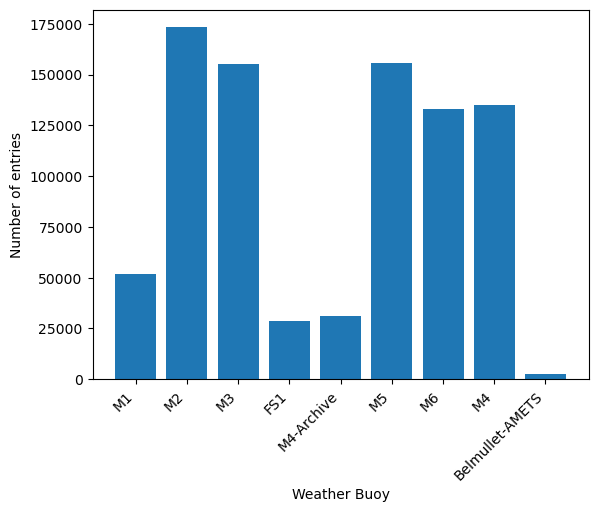

In [61]:
station_list = df['station_id'].unique()
station_values = []
for station_name in station_list:
    count = len(df[df['station_id'] == station_name])
    station_values.append(count)

print(station_list)
print(station_values)

plt.bar(station_list, station_values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Weather Buoy')
plt.ylabel('Number of entries')
plt.show()

For our dataset we want there to be data reading from all weather buoys. This is so that there is a ground truth to compare to the models prediction. In this data, there are several weather buoys that have far less reading then others. This is mostly because they are older and out of commission. Removing the weather buoys stations with less entries will make a minor difference to the amount of data we have but it will allow us to only use data where all of the buoys data is available.

In [35]:
# Only keep operational weather buoy stations
df_filtered = df[df['station_id'].isin(['M2', 'M3', 'M4', 'M5', 'M6'])]

# Remove unneeded column
df_filtered = df_filtered.drop(['QC_Flag'], axis=1)
df_filtered

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
1890,M2,-5.430200,53.483600,2001-05-03T14:00:00Z,1014.800,350.0,7.980,11.700,1.100,4.000,NaN,NaN,8.600,5.8,8.800,82.500
1892,M2,-5.430200,53.483600,2001-05-03T15:00:00Z,1014.600,360.0,NaN,11.700,1.000,4.000,NaN,NaN,8.700,NaN,8.900,NaN
1894,M2,-5.430200,53.483600,2001-05-03T16:00:00Z,1014.200,350.0,7.980,11.700,1.000,5.000,NaN,NaN,8.800,5.0,8.700,77.000
1896,M2,-5.430200,53.483600,2001-05-03T17:00:00Z,1014.200,360.0,8.950,11.700,0.800,5.000,NaN,NaN,8.800,5.1,8.700,77.600
1898,M2,-5.430200,53.483600,2001-05-03T18:00:00Z,1014.000,360.0,7.980,11.700,0.800,5.000,NaN,NaN,8.900,5.8,8.600,80.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866467,M2,-5.430200,53.483600,2024-07-11T12:00:00Z,1020.386,0.0,14.686,19.582,1.172,4.922,357.0,1.719,12.998,NaN,12.913,83.594
866468,M3,-10.548261,51.215956,2024-07-11T12:00:00Z,1024.097,334.0,15.939,19.013,1.406,4.336,336.0,2.031,13.975,NaN,14.381,81.348
866469,M4,-9.999136,54.999967,2024-07-11T12:00:00Z,1025.037,347.0,10.132,12.751,1.523,4.570,4.0,2.344,12.900,NaN,13.310,75.000
866470,M5,-6.704336,51.690425,2024-07-11T12:00:00Z,1021.118,352.0,17.874,22.770,1.172,3.984,301.0,2.344,12.949,NaN,15.172,84.961


In [36]:
# Shows the total amount of null values per feature
null_values = df_filtered.isnull().sum()
null_values

station_id                  0
longitude                   0
latitude                    0
time                        0
AtmosphericPressure     16956
WindDirection           59032
WindSpeed               91184
Gust                   106841
WaveHeight             104710
WavePeriod             103016
MeanWaveDirection      422351
Hmax                   415694
AirTemperature          34877
DewPoint               435000
SeaTemperature          56539
RelativeHumidity       100310
dtype: int64

This data has a lot of null values that need to be dealt with before the data can be used to train the model. As this is time series data interpolation will work well to replace most of the missing values.
Additionally, some of the features have nearly 50% missing values. This could largely effect the performance of the model so MeanWaveDirection, Hmax and DewPoint will be removed. 

In [37]:
# Drop the columns with mostly null values. 
df_filtered = df_filtered.drop(['MeanWaveDirection', 'Hmax', 'DewPoint'], axis=1)

time_counts = df_filtered['time'].value_counts()
common_times = time_counts[time_counts == 5].index

df_common_times = df_filtered[df_filtered['time'].isin(common_times)]

df_interpolated = df_common_times.groupby('station_id').apply(lambda group: group.interpolate(method='linear'))
df_interpolated = df_interpolated.reset_index(drop=True)

df_interpolated = df_interpolated.fillna(method='ffill')
df = df_interpolated.fillna(method='bfill')

# Shows the new total amount of null values per feature
null_values = df.isnull().sum()
null_values

station_id             0
longitude              0
latitude               0
time                   0
AtmosphericPressure    0
WindDirection          0
WindSpeed              0
Gust                   0
WaveHeight             0
WavePeriod             0
AirTemperature         0
SeaTemperature         0
RelativeHumidity       0
dtype: int64

Normalise the data. 

In [38]:
# Standardize the data
standardScaler = StandardScaler()
# 4 is the index of AtmosphericPressure, the first feature that we want to standardize
df_norm = pd.DataFrame(standardScaler.fit_transform(df.iloc[:, 4:]), 
                       columns=df.iloc[:, 4:].columns,
                       index=df.iloc[:, 4:].index)

# Concatenate the non-normalized part with the normalized part
df_not_norm = df.iloc[:, :4]
df = pd.concat([df_not_norm, df_norm], axis=1)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,388140.0,-9.712657e+00,3.639304,-15.881350,-10.548261,-9.999136,-6.704336,-5.430200
latitude,388140.0,5.289295e+01,1.347580,51.215956,51.690425,53.074820,53.483600,54.999967
AtmosphericPressure,388140.0,9.474621e-13,1.000001,-8.803825,-0.593639,0.109505,0.703514,2.822691
WindDirection,388140.0,4.662994e-16,1.000001,-2.266209,-0.612979,0.158528,0.753691,1.701543
WindSpeed,388140.0,3.646479e-14,1.000001,-2.249362,-0.769269,-0.033433,0.693835,6.171167
Gust,388140.0,-9.836369e-15,1.000001,-2.228196,-0.724253,-0.079706,0.658086,5.936066
WaveHeight,388140.0,9.319515e-13,1.000001,-1.506834,-0.727126,-0.201937,0.491088,9.221940
WavePeriod,388140.0,-6.385308e-13,1.000001,-3.582185,-0.735282,-0.027260,0.583595,5.897616
AirTemperature,388140.0,2.665053e-14,1.000001,-4.106620,-0.704403,0.069787,0.797527,3.807721
SeaTemperature,388140.0,-4.404989e-13,1.000001,-5.945127,-0.808154,-0.017958,0.796423,3.565598


Currently the data is in a tabular format which is not as suitable for a graph. Instead, we will create the static values of the graph (distances and indices) and convert our tabular data into a tensorflow GraphTensor dataset to be used as the node features.

In [39]:
# Calculate the average distance between each station
average_coordinates = df.groupby('station_id')[['longitude', 'latitude']].mean()
X = average_coordinates.values

knn = NearestNeighbors(n_neighbors=3)
knn.fit(average_coordinates)

distances, indices = knn.kneighbors(average_coordinates)

distances, indices

(array([[0.        , 2.19974979, 4.81399471],
        [0.        , 3.82364715, 3.87309698],
        [0.        , 3.82364715, 4.66998665],
        [0.        , 2.19974979, 3.87309698],
        [0.        , 5.64776183, 6.18923521]]),
 array([[0, 3, 2],
        [1, 2, 3],
        [2, 1, 3],
        [3, 0, 1],
        [4, 1, 2]]))

As the nodes are weather buoy station around Ireland, buoys shouldn't have edges that connect over land. We can manually remove these connections by setting removed edges to -1.

In [40]:
# Function to remove an edge
def remove_edge(indices, distances, node_from, node_to):
    # Find the row in the indices list that corresponds to node_from
    for i, row in enumerate(indices):
        if row[0] == node_from:
            # Find the index of the node_to in the row
            idx = np.where(row == node_to)[0]
            if idx.size > 0:
                idx = idx[0]
                # Remove the edge from the indices list
                new_indices_row = np.delete(indices[i], idx)
                # Remove the corresponding distance
                new_distances_row = np.delete(distances[i], idx)
                # Update the indices and distances arrays
                indices[i] = np.pad(new_indices_row, (0, indices.shape[1] - new_indices_row.shape[0]), 'constant', constant_values=-1)
                distances[i] = np.pad(new_distances_row, (0, distances.shape[1] - new_distances_row.shape[0]), 'constant', constant_values=-1)
            break

# Example: Remove the edge from node 1 to node 3
remove_edge(indices, distances, 0, 2)
remove_edge(indices, distances, 2, 3)

indices

array([[ 0,  3, -1],
       [ 1,  2,  3],
       [ 2,  1, -1],
       [ 3,  0,  1],
       [ 4,  1,  2]])

## Displaying the Graph

In [41]:
# Creating the graph
G = nx.Graph()

# Adding the nodes
for idx, row in average_coordinates.iterrows():
    G.add_node(row.name, pos=(row['longitude'], row['latitude']))

# Adding the edges
for i, neighbors in enumerate(indices):
    for neighbor in neighbors[1:]:
        # Don't include edges with neighbor -1
        if i == -1 or neighbor == -1:
            continue
        i_name = average_coordinates.iloc[i].name
        neighbor_name = average_coordinates.iloc[neighbor].name

        G.add_edge(i_name, neighbor_name)

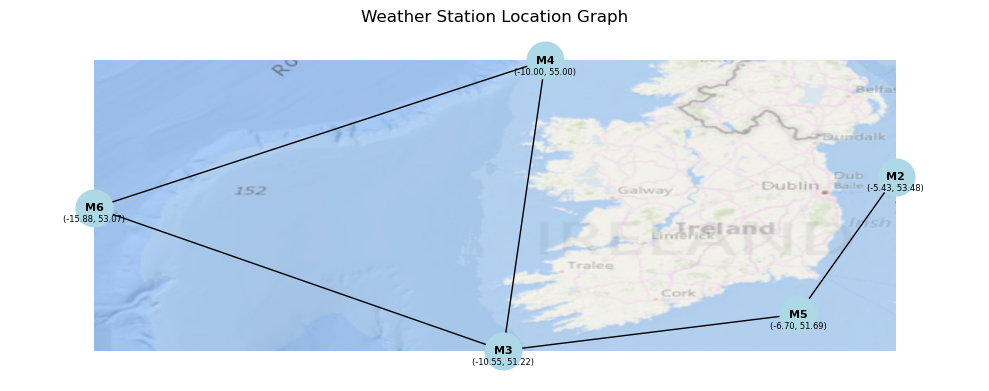

In [42]:
# Loading an image of Ireland
map_img = matplotlib.image.imread('./images/ireland_map.png')

min_lon = average_coordinates['longitude'].min()
max_lon = average_coordinates['longitude'].max()
min_lat = average_coordinates['latitude'].min()
max_lat = average_coordinates['latitude'].max()

fig = matplotlib.pyplot.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(map_img, extent=[min_lon, max_lon, min_lat, max_lat], aspect='equal')

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=8, font_weight='bold')

pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] - 0.15)

node_attrs = {node: f'({coords[0]:.2f}, {coords[1]:.2f})' for node, coords in pos.items()}
nx.draw_networkx_labels(G, pos_attrs, labels=node_attrs, font_size=6)

matplotlib.pyplot.title('Weather Station Location Graph')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [43]:
# Display the cleaned data
df

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,AirTemperature,SeaTemperature,RelativeHumidity
0,M2,-5.43020,53.48360,2007-05-03T09:00:00Z,0.559705,-1.604917,-1.215262,-1.153951,-1.319704,-0.619747,-0.634022,-1.433707,1.004099
1,M2,-5.43020,53.48360,2007-05-03T10:00:00Z,0.575684,-1.825348,-1.067533,-1.153951,-1.319704,-0.619747,-0.669213,-1.433707,1.004099
2,M2,-5.43020,53.48360,2007-05-03T12:00:00Z,0.575684,-1.604917,-0.919804,-1.046526,-1.257327,-1.212235,-0.669213,-1.340688,1.004099
3,M2,-5.43020,53.48360,2007-05-03T13:00:00Z,0.591663,-2.045779,-1.067533,-0.939102,-1.257327,-1.804722,-0.704403,-1.340688,1.004099
4,M2,-5.43020,53.48360,2007-05-03T14:00:00Z,0.591663,-2.045779,-1.215262,-1.153951,-1.257327,-1.804722,-0.669213,-1.247669,1.004099
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388135,M6,-15.88135,53.07482,2024-07-11T08:00:00Z,1.206683,1.569285,-0.819792,-0.882919,-0.775780,-0.527319,0.556824,0.633640,-0.473767
388136,M6,-15.88135,53.07482,2024-07-11T09:00:00Z,1.231051,1.635414,-0.786110,-0.931797,-0.775780,-0.665961,0.556824,0.626663,-0.523156
388137,M6,-15.88135,53.07482,2024-07-11T10:00:00Z,1.250545,1.558263,-1.038430,-1.090785,-0.775780,-0.596640,0.574067,0.643872,-0.588979
388138,M6,-15.88135,53.07482,2024-07-11T11:00:00Z,1.276910,1.459069,-0.903850,-0.980782,-0.775780,-0.527319,0.608202,0.678754,-0.638368


Currently the data is in a tabular format which is not as suitable for a graph. Instead, we will create the static values of the graph (distances and indices) and convert our tabular data into a tensorflow GraphTensor dataset to be used as the node features.

In [44]:
group_size = 5  # The number of weather buoy stations

result = (df.drop('longitude', axis=1) # Remove the longitude
            .drop('latitude', axis=1) # Remove the latitude
            .groupby('time') # Group all entries with the same time
            .filter(lambda x: x['station_id'].nunique() == group_size) # Filter out groups where not all stations are in the group
            .groupby('time') # Group all entries with the same time
            .apply(lambda x: x.drop(columns='time').to_dict(orient='list')) # Remove the time and convert to a dict
            )

result

time
2007-05-03T09:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T10:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T12:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T13:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T14:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
                                              ...                        
2024-07-11T08:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T09:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T10:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T11:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T12:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
Length: 77628, dtype: object

In [45]:
ground_truth_list = []
input_list = []
for time, group in result.items():
    if len(group['station_id']) == group_size:
        rand_num = np.random.randint(0, 4) # The index of the stations are 0 to 4
        # The [1:] is to remove the station_id
        ground_truth_list.append([v for k, v in group.items()][1:])
        # One of the stations features are masked with 0s
        input_list.append([v[:rand_num] + [0] +  v[rand_num+1:] for _, v in group.items()][1:])

# Convert the lists into tf tensors
ground_truth_tensor = tf.convert_to_tensor(ground_truth_list)
input_tensor = tf.convert_to_tensor(input_list)

# Change the shape of the tensors from [time/batch, features, station] to [time/batch, station, features]
input_tensor = tf.transpose(input_tensor, perm=[0, 2, 1])
ground_truth_tensor = tf.transpose(ground_truth_tensor, perm=[0, 2, 1])

input_tensor

<tf.Tensor: shape=(77628, 5, 9), dtype=float32, numpy=
array([[[ 0.5597051 , -1.6049174 , -1.2152616 , ..., -0.63402236,
         -1.4337068 ,  1.0040994 ],
        [ 0.5916625 , -1.7151327 , -1.9539044 , ...,  0.45688283,
         -0.08493178,  0.3298517 ],
        [ 0.68753487, -1.7151327 , -0.47661874, ...,  0.06978745,
         -0.3174792 ,  0.16128975],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.7514497 , -1.825348  , -1.6584473 , ..., -0.56364137,
         -0.08493178,  0.9198184 ]],

       [[ 0.57568383, -1.825348  , -1.067533  , ..., -0.6692128 ,
         -1.4337068 ,  1.0040994 ],
        [ 0.6076412 , -1.2742714 , -1.9539044 , ...,  0.6680258 ,
         -0.03842229,  0.24557072],
        [ 0.71949226, -1.7151327 , -0.7720759 , ...,  0.10497794,
         -0.22446021,  0.16128975],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.7514497 , -1.

In [46]:
# Create the dataset from the tensors 
tf_dataset = tf.data.Dataset.from_tensor_slices({"masked_station_features": input_tensor , "ground_truth_station_features": ground_truth_tensor, })

# One example from dataset
list(tf_dataset.take(1).as_numpy_iterator())

2024-07-29 15:38:54.511944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]


[{'masked_station_features': array([[ 0.5597051 , -1.6049174 , -1.2152616 , -1.1539507 , -1.3197039 ,
          -0.6197474 , -0.63402236, -1.4337068 ,  1.0040994 ],
         [ 0.5916625 , -1.7151327 , -1.9539044 , -2.0133467 , -0.8830678 ,
           0.5652277 ,  0.45688283, -0.08493178,  0.3298517 ],
         [ 0.68753487, -1.7151327 , -0.47661874, -0.18573381, -0.8830678 ,
          -0.6197474 ,  0.06978745, -0.3174792 ,  0.16128975],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.7514497 , -1.825348  , -1.6584473 , -1.4762242 , -0.69593805,
          -0.6197474 , -0.56364137, -0.08493178,  0.9198184 ]],
        dtype=float32),
  'ground_truth_station_features': array([[ 0.5597051 , -1.6049174 , -1.2152616 , -1.1539507 , -1.3197039 ,
          -0.6197474 , -0.63402236, -1.4337068 ,  1.0040994 ],
         [ 0.5916625 , -1.7151327 , -1.9539044 , -2.0133467 , -0.8830678 ,
           0

In this example above, it is easier to see how this initial dataset is structured. Each entry in the dataset is made up of two sets of features: the masked station features, which are the input features for the nodes in the graph, with a shape of [5, 9] ([number of nodes, number of features per node]), where one of the nodes has its values replaced with 0s; and the ground truth station features, which are the actual feature values from the node that had been masked, with a shape of [5, 9]. The model will take the masked station features as input and use them to predict the ground truth station features.

It is important to note that this is not the final dataset. It needs to be converted into a form that can be interpreted by the Tensorflow GNN model.

## Creating the Graph Tensor Dataset

For simplicity, the edges and their features will be the same throughout all entires in the dataset. We have already calculated the average distance and indices (not including edges across land). 

In [47]:
# Prepare edges and edge features
edges = []
edge_features = []
num_nodes = indices.shape[0]

# creating the edges and edge features in the correct format
for i in range(num_nodes):
    # Use the precalculated indices and distances for the graph
    for j in range(indices.shape[1]):
        if indices[i, j] != -1:
            edges.append([i, indices[i, j]])
            edge_features.append([distances[i, j]])

edges = np.array(edges, dtype=np.int32)
edge_features = np.array(edge_features, dtype=np.float32)

edges

array([[0, 0],
       [0, 3],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 1],
       [3, 3],
       [3, 0],
       [3, 1],
       [4, 4],
       [4, 1],
       [4, 2]], dtype=int32)

In [48]:
# Convert edges and edge features to tensors
edges = tf.constant(edges)
edge_features = tf.constant(edge_features)
nodes = tf.constant(list(tf_dataset.take(1).as_numpy_iterator())[0]['masked_station_features'])
feature_dim =  tf.constant(list(tf_dataset.take(1).as_numpy_iterator())[0]['masked_station_features']).shape[1]

# This function will take a masked features tensor, edges and edge_features to convert them into a graph tensor
def create_graph_tensor(masked_features, edges, edge_features):
    # Create node features dictionary
    node_features = {"feat": masked_features}
    
    # Adjust dimensions as necessary
    hidden_state = tf.random.normal([nodes.shape[0], 32])  
    node_features["hidden_state"] = hidden_state
    
    # Create GraphTensor
    graph = tfgnn.GraphTensor.from_pieces(
        node_sets={"nodes": tfgnn.NodeSet.from_fields(
            sizes=tf.constant([nodes.shape[0]]),
            features=node_features
        )},
        edge_sets={"edges": tfgnn.EdgeSet.from_fields(
            sizes=tf.constant([edges.shape[0]]),
            adjacency=tfgnn.Adjacency.from_indices(
                ("nodes", edges[:, 0]),
                ("nodes", edges[:, 1])
            ),
            features={"distance": edge_features}
        )}
    )
    return graph

# This preprocessing function will be used on every entry in the dataset to convert the model inputs into graph tensors
@tf.function
def preprocess(data):
    masked_features = data['masked_station_features']
    graph = create_graph_tensor(masked_features, edges, edge_features)

    ground_truth = data['ground_truth_station_features']
    ground_truth = tf.reshape(ground_truth, (tf.shape(ground_truth)[0], -1, feature_dim))
    return graph, ground_truth

2024-07-29 15:38:54.663240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]
2024-07-29 15:38:54.699174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]


### Message Passing Neural Network
GNNs take a graph as an input and then output a graph with updated node, edge, and global embeddings. 
The specific model that we will use is called the [message passing neural network](https://arxiv.org/abs/1704.01212) (MPNN).
This GNN layer uses a separate multilayer perception (MLP) on each component of the graph (nodes and edges because we are not using global features in our example) to aggregate and pass information across the graph. 
<img src="images/gnn_update_diagram.png" alt="drawing" width="800"/>

A MPNN uses dense layers with a non-linear (RELU) activation to update the values of a node features from the features of it's neighboring node's features and connecting edges. Using non-linear layers allows the GNN to learn complex relationships between nodes and their neighbours.  
Similar to convolutions on an image, at first a single update will only pass information in its local neighbourhood but after several updates, information can permeate throughout the entire graph. Additionally, by using multiple neural network update layers, the model can learn different functions for different layers. 

<img src="images/gnn_prediction_diagram.png" alt="drawing" width="800"/>

After it has completed the graph update layers, for a node level prediction task like ours, we will use a linear layer to predict a tensor of shape [9] resulting in a final output tensor of shape [5,9] for our 5 nodes that can then be compared to our ground truth features from our dataset to calculate the loss. 


In [49]:
# Define the MPNN layer and model
class MPNNLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(MPNNLayer, self).__init__()
        self.units = units
        self.mpnn = vanilla_mpnn.VanillaMPNNGraphUpdate(
            units=units,
            message_dim=units,
            receiver_tag=tfgnn.SOURCE,
            edge_feature="distance",
        )

    def call(self, graph):
        return self.mpnn(graph)
  
class MPNN_Model(tf.keras.Model):
    def __init__(self, output_units):
        super(MPNN_Model, self).__init__()
        self.mpnn1 = MPNNLayer(units=32)
        self.mpnn2 = MPNNLayer(units=16)
        self.dense = tf.keras.layers.Dense(output_units) 

    def call(self, graph):
        # Two graph update layers 
        graph = self.mpnn1(graph)
        graph = self.mpnn2(graph)

        # Retrieving the updated node features from the graph
        x = graph.node_sets["nodes"]["feat"]

        # Using a linear "classification" (our example is a regression task) layer on the updated node features
        output = self.dense(x)
        return output
    
# Instantiate the model
# The output units should be the same size as the node features we are trying to predict
model = MPNN_Model(output_units=9) 

You can see the code for the [vanilla_mpnn.VanillaMPNNGraphUpdate() function](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/models/vanilla_mpnn/layers.py) from the Tensorflow-GNN github repository.

In [50]:
# Randomise the order of the dataset
buffer_size = len(tf_dataset)
tf_dataset = tf_dataset.shuffle(buffer_size)

# Split the dataset
dataset_size = len(tf_dataset)
# This dataset split is 80% training data and 20% testing data
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)

# Batch and preprocess the datasets
batch_size = 8
train_dataset = train_dataset.batch(batch_size).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

2024-07-29 15:38:55.220629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [?,5,9]
	 [[{{node args_0}}]]
2024-07-29 15:38:55.250317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [?,5,9]
	 [[{{node args_0}}]]


In [51]:
# mse = mean square error 
# mae = mean absolute error
# mape = mean absolute percentage error
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse', metrics=['mae', 'mape'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

2024-07-29 15:38:55.407110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32 and shape [13,2]
	 [[{{node Placeholder/_13}}]]
2024-07-29 15:38:55.407596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_0}}]]


Epoch 1/5
7758/7763 [============================>.] - ETA: 0s - loss: 0.4913 - mae: 0.4587 - mape: 181.9460

2024-07-29 15:39:18.403260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]
2024-07-29 15:39:18.403746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype float and shape [13,1]
	 [[{{node Placeholder/_14}}]]


7763/7763 [==============================] - 27s 3ms/step - loss: 0.4911 - mae: 0.4585 - mape: 181.8675 - val_loss: 0.2168 - val_mae: 0.2404 - val_mape: 77.7812
Epoch 2/5
7763/7763 [==============================] - 33s 4ms/step - loss: 0.2003 - mae: 0.1944 - mape: 44.7961 - val_loss: 0.1933 - val_mae: 0.1695 - val_mape: 27.0628
Epoch 3/5
7763/7763 [==============================] - 28s 4ms/step - loss: 0.1939 - mae: 0.1696 - mape: 28.0922 - val_loss: 0.1940 - val_mae: 0.1702 - val_mape: 28.7253
Epoch 4/5
7763/7763 [==============================] - 25s 3ms/step - loss: 0.1938 - mae: 0.1696 - mape: 28.0918 - val_loss: 0.1930 - val_mae: 0.1679 - val_mape: 26.5648
Epoch 5/5
7763/7763 [==============================] - 30s 4ms/step - loss: 0.1937 - mae: 0.1697 - mape: 28.2923 - val_loss: 0.1936 - val_mae: 0.1716 - val_mape: 30.6695


In [52]:
# Evaluate the final metrics of our model
evaluation = model.evaluate(test_dataset)
print("Test loss:", evaluation[0])
print("Test MAE:", evaluation[1])
print("Test MAPE:", evaluation[2])

1941/1941 [==============================] - 6s 3ms/step - loss: 0.1925 - mae: 0.1711 - mape: 30.4935
Test loss: 0.19254299998283386
Test MAE: 0.17110590636730194
Test MAPE: 30.493492126464844
